
# TTS Inference

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This script currently uses a two step inference procedure. First, a model is used to generate a mel spectrogram from text. Second, a model is used to generate audio from a mel spectrogram.

Currently supported models are:
Mel Spectrogram Generators:
- Tacotron 2
- Glow-TTS

Audio Generators
- Grifflin-Lim
- WaveGlow
- SqueezeWave
- Deep Griffin-Lim Iteration

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# !pip install nemo-toolkit[tts]==1.0.0b1

In [ ]:
supported_spec_gen = ["tacotron2", "glow_tts", "talknet"]
supported_audio_gen = ["waveglow", "squeezewave", "two_stages"]

print("Choose one of the following spectrogram generators:")
print([model for model in supported_spec_gen])
spectrogram_generator = input()
print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = input()

assert spectrogram_generator in supported_spec_gen
assert audio_generator in supported_audio_gen

if audio_generator=="two_stages":
    print("Choose one of the following mel-to-spec convertor:")
    # supported_mel2spec = ["psuedo_inverse", "encoder_decoder"] - No encoder_decoder checkpoint atm
    supported_mel2spec = ["psuedo_inverse"]
    print([model for model in supported_mel2spec])
    mel2spec = input()
    print("Choose one of the following linear spectrogram vocoders:")
    # supported_linear_vocoders = ["griffin_lim", "degli"]  - No deep_gli checkpoint atm
    supported_linear_vocoders = ["griffin_lim"]
    print([model for model in supported_linear_vocoders])
    linvocoder = input()
    assert mel2spec in supported_mel2spec
    assert linvocoder in supported_linear_vocoders

# Load model checkpoints

Note: For best quality with Glow TTS, please update the glow tts yaml file with the path to cmudict

In [ ]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.asr.parts import parsers
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

SAMPLE_RATE = 22050
NFFT = 1024
NMEL = 80
FMAX = None


def load_spectrogram_model():
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "Tacotron2-22050Hz"       
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "GlowTTS-22050Hz"
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetDursModel
        from nemo.collections.tts.models import TalkNetSpectModel
    else:
        raise NotImplementedError

    if spectrogram_generator == "talknet":
        model = TalkNetSpectModel.load_from_checkpoint(checkpoint_path="./sn2.ckpt")
        model.load_durs_predictor("./dn2.ckpt")
    else:
        model = SpecModel.from_pretrained(pretrained_model)
    
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        SAMPLE_RATE = model._cfg.sample_rate or SAMPLE_RATE
        NFFT = model._cfg.n_fft or NFFT
        NMEL = model._cfg.n_mels or NMEL
        FMAX = model._cfg.fmax or FMAX
    return model


def validate_parameters(sample_rate, n_fft, n_mels, fmax):
    global SAMPLE_RATE
    global NFFT
    global NMEL
    global FMAX
    if sample_rate is not None and SAMPLE_RATE is not None:
        assert sample_rate == SAMPLE_RATE
    if n_fft is not None and NFFT is not None:
        assert n_fft == NFFT
    if n_mels is not None and NMEL is not None:
        assert n_mels == NMEL
    if fmax is not None and FMAX is not None:
        assert fmax == FMAX
        
def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "WaveGlow-22050Hz"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "SqueezeWave-22050Hz"
    elif audio_generator == "two_stages":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': NFFT, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': SAMPLE_RATE, 'n_fft': NFFT, 
                                   'mel_fmin': 0, 'mel_fmax': FMAX, 'mel_freq': NMEL}}}
        model = TwoStagesModel(cfg)
        if mel2spec == "encoder_decoder":
            from nemo.collections.tts.models.ed_mel2spec import EDMel2SpecModel
            pretrained_mel2spec_model = "EncoderDecoderMelToSpec-22050Hz"
            mel2spec_model = EDMel2SpecModel.from_pretrained(pretrained_mel2spec_model)
            model.set_mel_to_spec_model(mel2spec_model)

        if linvocoder == "degli":
            from nemo.collections.tts.models.degli import DegliModel
            pretrained_linvocoder_model = "DeepGriffinLim-22050Hz"
            linvocoder_model = DegliModel.from_pretrained(pretrained_linvocoder_model)
            model.set_linear_vocoder(linvocoder_model)
            
        TwoStagesModel = True

    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model)
        with open_dict(model._cfg):
            validate_parameters(model._cfg.sample_rate, model._cfg.n_fft, model._cfg.n_mels, model._cfg.fmax)
    return model

spec_gen = load_spectrogram_model().cuda()
vocoder = load_vocoder_model().cuda()

In [ ]:
def infer(spec_gen_model, vocder_model, str_input):
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input).cuda()
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocder_model.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

# Show Audio and Spectrogram

In [ ]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=SAMPLE_RATE)

In [ ]:
%matplotlib inline
imshow(spec, origin="lower")
plt.show()

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# !pip install nemo-toolkit[tts]==1.0.0b1

'\nYou can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.\nInstructions for setting up Colab are as follows:\n1. Open a new Python 3 notebook.\n2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)\n3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)\n4. Run this cell to set up dependencies.\n'

In [2]:
supported_spec_gen = ["tacotron2", "glow_tts", "talknet"]
supported_audio_gen = ["waveglow", "squeezewave", "two_stages"]

print("Choose one of the following spectrogram generators:")
print([model for model in supported_spec_gen])
spectrogram_generator = input()
print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = input()

assert spectrogram_generator in supported_spec_gen
assert audio_generator in supported_audio_gen

if audio_generator=="two_stages":
    print("Choose one of the following mel-to-spec convertor:")
    # supported_mel2spec = ["psuedo_inverse", "encoder_decoder"] - No encoder_decoder checkpoint atm
    supported_mel2spec = ["psuedo_inverse"]
    print([model for model in supported_mel2spec])
    mel2spec = input()
    print("Choose one of the following linear spectrogram vocoders:")
    # supported_linear_vocoders = ["griffin_lim", "degli"]  - No deep_gli checkpoint atm
    supported_linear_vocoders = ["griffin_lim"]
    print([model for model in supported_linear_vocoders])
    linvocoder = input()
    assert mel2spec in supported_mel2spec
    assert linvocoder in supported_linear_vocoders

Choose one of the following spectrogram generators:
['tacotron2', 'glow_tts', 'talknet']
talknet
Choose one of the following audio generators:
['waveglow', 'squeezewave', 'two_stages']
waveglow


# Load model checkpoints

Note: For best quality with Glow TTS, please update the glow tts yaml file with the path to cmudict

In [3]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.asr.parts import parsers
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

SAMPLE_RATE = 22050
NFFT = 1024
NMEL = 80
FMAX = None


def load_spectrogram_model():
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "Tacotron2-22050Hz"       
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "GlowTTS-22050Hz"
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetDursModel
        from nemo.collections.tts.models import TalkNetSpectModel
    else:
        raise NotImplementedError

    if spectrogram_generator == "talknet":
        model = TalkNetSpectModel.load_from_checkpoint(checkpoint_path="./sn2.ckpt")
        model.load_durs_predictor("./dn2.ckpt")
    else:
        model = SpecModel.from_pretrained(pretrained_model)
    
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        SAMPLE_RATE = model._cfg.sample_rate or SAMPLE_RATE
        NFFT = model._cfg.n_fft or NFFT
        NMEL = model._cfg.n_mels or NMEL
        FMAX = model._cfg.fmax or FMAX
    return model


def validate_parameters(sample_rate, n_fft, n_mels, fmax):
    global SAMPLE_RATE
    global NFFT
    global NMEL
    global FMAX
    if sample_rate is not None and SAMPLE_RATE is not None:
        assert sample_rate == SAMPLE_RATE
    if n_fft is not None and NFFT is not None:
        assert n_fft == NFFT
    if n_mels is not None and NMEL is not None:
        assert n_mels == NMEL
    if fmax is not None and FMAX is not None:
        assert fmax == FMAX
        
def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "WaveGlow-22050Hz"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "SqueezeWave-22050Hz"
    elif audio_generator == "two_stages":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': NFFT, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': SAMPLE_RATE, 'n_fft': NFFT, 
                                   'mel_fmin': 0, 'mel_fmax': FMAX, 'mel_freq': NMEL}}}
        model = TwoStagesModel(cfg)
        if mel2spec == "encoder_decoder":
            from nemo.collections.tts.models.ed_mel2spec import EDMel2SpecModel
            pretrained_mel2spec_model = "EncoderDecoderMelToSpec-22050Hz"
            mel2spec_model = EDMel2SpecModel.from_pretrained(pretrained_mel2spec_model)
            model.set_mel_to_spec_model(mel2spec_model)

        if linvocoder == "degli":
            from nemo.collections.tts.models.degli import DegliModel
            pretrained_linvocoder_model = "DeepGriffinLim-22050Hz"
            linvocoder_model = DegliModel.from_pretrained(pretrained_linvocoder_model)
            model.set_linear_vocoder(linvocoder_model)
            
        TwoStagesModel = True

    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model)
        with open_dict(model._cfg):
            validate_parameters(model._cfg.sample_rate, model._cfg.n_fft, model._cfg.n_mels, model._cfg.fmax)
    return model

spec_gen = load_spectrogram_model().cuda()
vocoder = load_vocoder_model().cuda()

[NeMo W 2020-10-22 04:56:22 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-22 04:56:22 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-22 04:56:22 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-22 04:56:22 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-22 04:56:22 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

ConfigAttributeError: Key 'vocab' is not in struct
	full_key: train_ds.dataset.vocab
	reference_type=Any
	object_type=dict

In [ ]:
def infer(spec_gen_model, vocder_model, str_input):
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input).cuda()
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocder_model.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

# Show Audio and Spectrogram

In [11]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=SAMPLE_RATE)

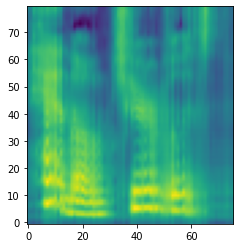

In [12]:
%matplotlib inline
imshow(spec, origin="lower")
plt.show()